# Classification with a Tabular Vector Borne Disease Dataset
## Playground Series - Season 3, Episode 13
## MultiClass

In [61]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

# グラフ
import seaborn as sns
#sns.set(font='Yu Gothic')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
# Congig
SEED = 42
FOLD = 5
pd.get_option('display.max_columns')
seed_everything(SEED)

In [30]:
train = pd.read_csv('./kaggle/input/train_folds.csv')
test = pd.read_csv('./kaggle/input/test.csv')
sample_submission = pd.read_csv('./kaggle/input/sample_submission.csv')
train.shape, test.shape

((707, 67), (303, 65))

In [31]:
test = test.astype('int64')

In [32]:
train.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis,kfold
0,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,3
2,2,0,1,1,1,0,1,1,1,1,...,1,1,1,1,0,1,1,1,0,3
3,3,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,2,1
4,4,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,1,0,0,3,2


In [33]:
test.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,708,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,709,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,710,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,711,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
sample_submission.head()

,id,prognosis
0,707,Dengue Zika Japanese_encephalitis
1,708,Dengue Zika Japanese_encephalitis
2,709,Dengue Zika Japanese_encephalitis
3,710,Dengue Zika Japanese_encephalitis
4,711,Dengue Zika Japanese_encephalitis


## EDA

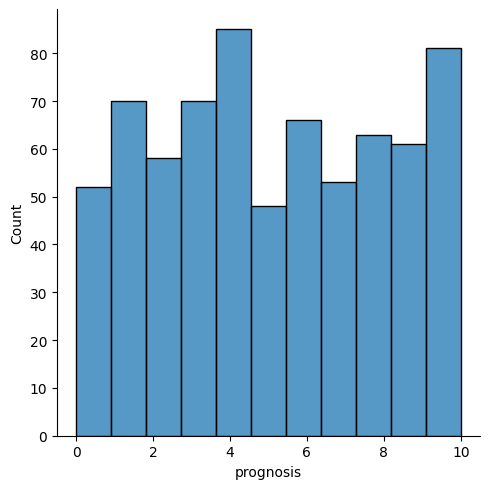

In [35]:
# Target
sns.displot(train['prognosis'], height=5)
plt.show()

<AxesSubplot: >

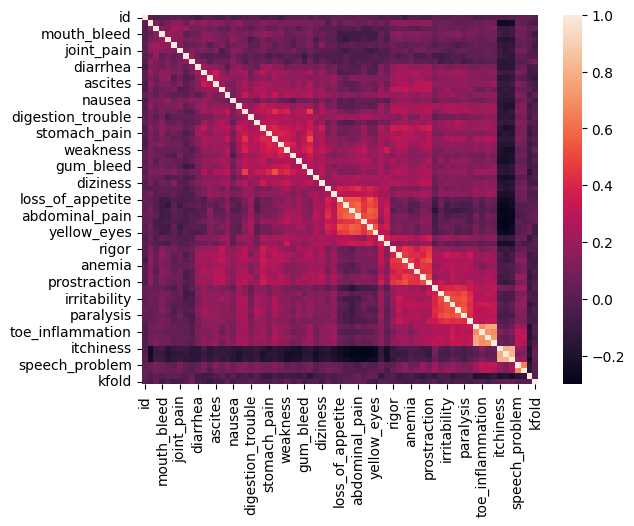

In [36]:
sns.heatmap(train.corr())

## 特徴量作成

## Train

In [37]:
useful_features = [c for c in train.columns if c not in ("id","prognosis","kfold")]

In [38]:
train.kfold.value_counts()

1    142
0    142
3    141
2    141
4    141
Name: kfold, dtype: int64

In [39]:
# LGBMのパラメータを設定
param = {
    'device_type': 'CPU',
    'num_threads': 4,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class' : 11,
    'learning_rate': 0.01,
    'verbosity': -1,
    'bagging_seed': SEED,
    'feature_fraction_seed': SEED,
    'seed': SEED,
    'max_depth' : -1,
    'feature_pre_filter': False,
    'lambda_l1': 0.00026736033973282354,
    'lambda_l2': 1.9789181864050404e-07,
    'num_leaves': 213,
    'feature_fraction': 0.716,
    'bagging_fraction': 0.5029517553397906,
    'bagging_freq': 2,
    'min_child_samples': 20
 }

In [40]:
test_predictions = []
#final_valid_predictions = {}
scores = []

for fold in range(FOLD):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test[useful_features]

    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.prognosis
    yvalid = xvalid.prognosis
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    lgb_train = lgb.Dataset(xtrain, ytrain)
    lgb_valid = lgb.Dataset(xvalid, yvalid)

    model = lgb.train(param,
                      lgb_train,
                      valid_names=['train', 'valid'],
                      valid_sets=[lgb_train, lgb_valid],
                      num_boost_round=10000,
                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(500)]
                      )
    
    # For Validation
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    
    # For Test
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    test_predictions.append(test_preds)
    
    # Lossを計算する
    score = log_loss(yvalid, preds_valid)
    print(f'fold {fold} log loss: {score}')
    scores.append(score)

print(np.mean(scores), np.std(scores))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	train's multi_logloss: 1.03786	valid's multi_logloss: 1.87525
fold 0 log loss: 1.8752482333724467
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 1.13735	valid's multi_logloss: 1.89588
fold 1 log loss: 1.895878615457328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	train's multi_logloss: 1.08475	valid's multi_logloss: 1.94008
fold 2 log loss: 1.9400801396962557
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	train's multi_logloss: 1.25905	valid's multi_logloss: 1.94456
fold 3 log loss: 1.9445646747292165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 1.17061	valid's multi_logloss: 1.96316
fold 4 log loss: 1.9631630872387

## 学習結果の解析

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

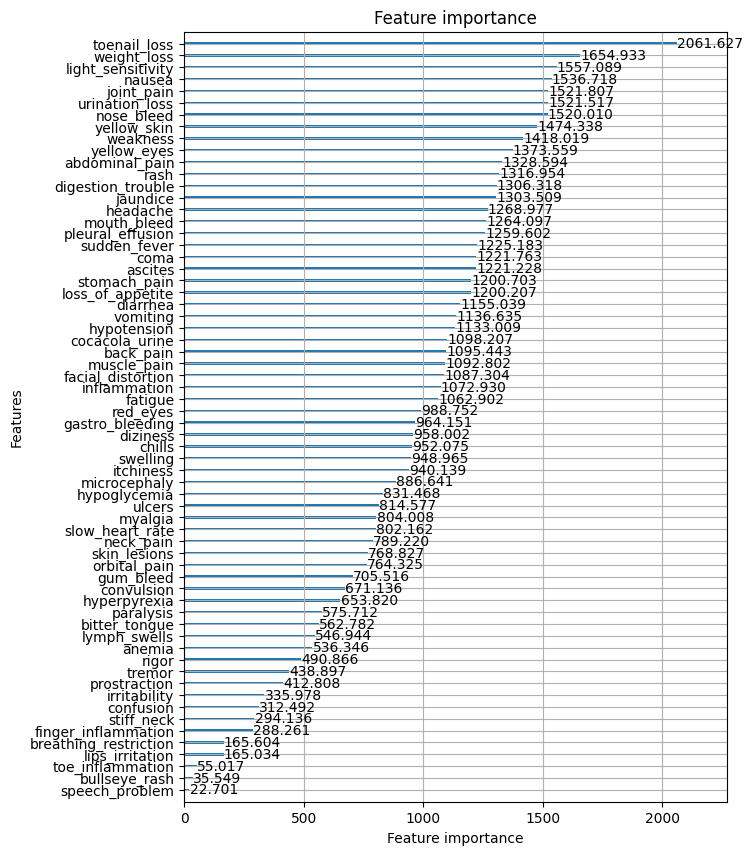

In [43]:
lgb.plot_importance(model, figsize=(7,10), importance_type='gain')

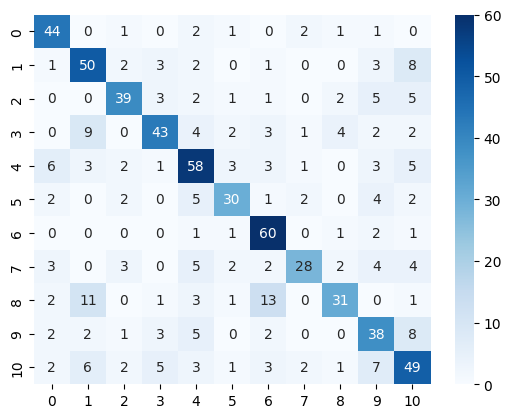

In [44]:
# confusion_matrix

#train_max = np.argmax(train_pred, axis=1) 一番大きいもの
train_pred = model.predict(train[useful_features], num_iteration=model.best_iteration).argmax(axis=1)
cm = confusion_matrix(train['prognosis'], train_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

## 提出

In [59]:
# Fold分の平均化
result = np.average(test_predictions, axis = 0)
result

array([[0.01321487, 0.10728177, 0.07880727, ..., 0.11622995, 0.03741868,
        0.08360164],
       [0.01661192, 0.03295787, 0.02339599, ..., 0.35055173, 0.03648314,
        0.07051465],
       [0.03866343, 0.0559437 , 0.06710271, ..., 0.03062174, 0.09360478,
        0.17309849],
       ...,
       [0.42660558, 0.02614609, 0.02767961, ..., 0.03738672, 0.02699189,
        0.06555977],
       [0.08564691, 0.04057095, 0.15636764, ..., 0.10097211, 0.04432889,
        0.08473339],
       [0.06090996, 0.04733129, 0.27874874, ..., 0.04176017, 0.09162752,
        0.17783957]])

In [46]:
result_1, result_2, result_3 = [], [], []
for i in range(len(result)):
    inner_ary = result[i]
    sort_ary = np.sort(inner_ary)
    result_1.append(np.where(inner_ary==sort_ary[-1])[0][0]) # 1番大きいものの位置
    result_2.append(np.where(inner_ary==sort_ary[-2])[0][0]) # 2番目に大きいものの位置
    result_3.append(np.where(inner_ary==sort_ary[-3])[0][0]) # 3番目に大きいものの位置
test['result_1'] = result_1
test['result_2'] = result_2
test['result_3'] = result_3
test

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,result_1,result_2,result_3
0,707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,8,1
1,708,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,8,6,5
2,709,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,4,10,9
3,710,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,10,3,9
4,711,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,4,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1005,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,9,2,4
299,1006,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,5,7
300,1007,1,0,0,1,1,0,1,1,1,...,1,1,0,0,0,0,0,0,4,5
301,1008,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,4,3,2


In [47]:
# 結果を文字列に置き換える
# Replace result with a text

for i in range(3):
    test['result_' + str(i + 1)] = test['result_' + str(i + 1)].\
    replace(0, 'Lyme_disease').\
    replace(1, 'Tungiasis').\
    replace(2, 'Zika').\
    replace(3, 'Rift_Valley_fever').\
    replace(4, 'West_Nile_fever').\
    replace(5, 'Malaria').\
    replace(6, 'Chikungunya').\
    replace(7, 'Plague').\
    replace(8, 'Dengue').\
    replace(9, 'Yellow_Fever').\
    replace(10, 'Japanese_encephalitis')
test

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,result_1,result_2,result_3
0,707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Rift_Valley_fever,Dengue,Tungiasis
1,708,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,Dengue,Chikungunya,Malaria
2,709,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,0,0,West_Nile_fever,Japanese_encephalitis,Yellow_Fever
3,710,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,Japanese_encephalitis,Rift_Valley_fever,Yellow_Fever
4,711,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,West_Nile_fever,Japanese_encephalitis,Plague
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1005,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,Yellow_Fever,Zika,West_Nile_fever
299,1006,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,Lyme_disease,Malaria,Plague
300,1007,1,0,0,1,1,0,1,1,1,...,1,1,0,0,0,0,0,Lyme_disease,West_Nile_fever,Malaria
301,1008,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,West_Nile_fever,Rift_Valley_fever,Zika


In [51]:
test['prognosis'] = test['result_1']+ ' ' + test['result_2']+ ' ' + test['result_3']

In [52]:
test.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,result_1,result_2,result_3,prognosis
0,707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Rift_Valley_fever,Dengue,Tungiasis,Rift_Valley_fever Dengue Tungiasis
1,708,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,Dengue,Chikungunya,Malaria,Dengue Chikungunya Malaria
2,709,1,1,0,1,1,1,1,0,1,...,0,1,0,0,0,0,West_Nile_fever,Japanese_encephalitis,Yellow_Fever,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,Japanese_encephalitis,Rift_Valley_fever,Yellow_Fever,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,West_Nile_fever,Japanese_encephalitis,Plague,West_Nile_fever Japanese_encephalitis Plague


In [53]:
sample_submission.head()

,id,prognosis
0,707,Dengue Zika Japanese_encephalitis
1,708,Dengue Zika Japanese_encephalitis
2,709,Dengue Zika Japanese_encephalitis
3,710,Dengue Zika Japanese_encephalitis
4,711,Dengue Zika Japanese_encephalitis


In [54]:
sample_submission['prognosis'] = test['prognosis']

In [55]:
sample_submission.head()

,id,prognosis
0,707,Rift_Valley_fever Dengue Tungiasis
1,708,Dengue Chikungunya Malaria
2,709,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Japanese_encephalitis Plague


In [57]:
#sample_submission.to_csv('./submission_20230501_1st.csv', index=False)

In [58]:
#!kaggle competitions submit -c playground-series-s3e13 -f ./submission_20230501_1st.csv -m "log"

100%|██████████████████████████████████████| 12.9k/12.9k [00:02<00:00, 4.51kB/s]
Successfully submitted to Classification with a Tabular Vector Borne Disease Dataset